# PyTorch入門

今回はおもちゃのデータを作って、そのデータを再現するような関数：

$$
\mathbb{R}^2 \ni {\bf x} \to y \in \{0,1,2,3,4 \} 
$$

を作ってみます。

## データ生成機

このノートブックでは、データは以下のような形式です。

1. 入力ベクトルは２次元実ベクトル：${\bf x} \in \mathbb{R}^2$
2. 予想させるラベルは整数値：$y \in \{0, 1, 2, 3, 4 \}$

このようなデータを、ある程度構造を持たせて適当に生成するようなクラスToyDataGeneratorを作っておきました。


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
rg = np.random.default_rng()

class ToyDataGenerator():
    def __init__(self, dim: int, n_class: int):
        self.mu_for_class_np = rg.normal(0, 1, size=(n_class, dim))
        self.dim = dim
        self.n_class = n_class
        
    def get_data(self, N_batch:int):
        x = []
        y = []
        for n in range(self.n_class):
            mu = self.mu_for_class_np[n]
            x = x + (rg.normal(0, .2, size=(N_batch//self.n_class,self.dim)) + mu).tolist()
            y = y + (n*np.ones(shape=(N_batch//self.n_class, 1))).tolist()   
        return np.array(x).astype(np.float32), np.array(y).astype(np.int32)

> <font color=dodgerblue>**ToyDataGeneratorの使い方**</font>
>
> 1. データ生成機を作る
> ```python
> dg = ToyDataGenerator(dim=入力次元, n_class=分類させたいクラス数)
> ```
> 2. dgで訓練用データを生成する
> ```python
> x_train, y_train = dg.get_data(N_batch=データ数)
> ```
> 3. dgで検証用データを生成する
> ```python
> x_test, y_test = dg.get_data(N_batch=データ数)
> ```




### 訓練用データを作って可視化してみる

作ったデータをplt.scatterでクラスごとに異なる色でプロットしてみます：

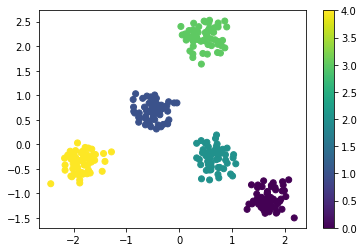

In [2]:
dg = ToyDataGenerator(dim=2, n_class=5)
x_train, y_train = dg.get_data(N_batch=300)

plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
    
plt.colorbar()
plt.show()

## PytorchのAPI＋自作クラスを使った訓練 

PyTorchのインポートはimport pytorch**ではなく** import torch です。

In [3]:
import torch

### 自作Sequentialクラス

tf.kerasのSequentialに似た、torch.nn.Sequentialというのがありますが、訓練などの処理は自分で書かねばなりません。tf.kerasに似せてtorch.nn.Sequentialを改造すると以下のような感じです：

In [4]:
class Sequential(torch.nn.Sequential):
    def forward(self, x):
        return super().forward(x)        
        
    def return_data_loader(self, x, y, batch_size=10):
        data = torch.utils.data.TensorDataset(torch.from_numpy(x), torch.from_numpy(y.reshape(-1).astype(np.int64)))
        return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
    def step(self, x_mini, y_mini, loss_fn, loss_list: list):
        x, y = torch.autograd.Variable(x_mini).float(), torch.autograd.Variable(y_mini)
        self.optimizer.zero_grad()
        loss = loss_fn(self.forward(x), y)
        loss_list.append(loss.data.numpy().tolist())
        loss.backward()
        self.optimizer.step()
    
    def fit(self, x, y, epochs: int, batch_size: int):
        training_data_loader = self.return_data_loader(x, y, batch_size)
        history = []
        loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters())
        for _ in range(epochs):
            loss_list = []
            for minibatch_index, (x_mini, y_mini) in enumerate(training_data_loader):
                self.step(x_mini, y_mini, loss_fn, loss_list)
            history.append(np.average(loss_list))
        return history

TensorFlowに比べ、随分ややこしい印象を受けるかもしれません。これはPyTorchでは楽ちんな処理（＝ややこしい部分は隠蔽された処理）が、わざと実装されておらず、実行したいことは明示的に全て書く必要があるためです。

楽ちんなコードになるような、PyTorchのラッパーがいくつかあるので、それを使うのも良いかもしれません。

### ニューラルネットワークを作る

Sequential(torch.nn.Sequential)に、順にどのようなニューラルネットワークの処理をさせたいか,で区切って書いていけば、そのようなネットワークを作ることができます。tf.kerasでは[]を書いていましたが、それが不要です。

> <font color=dodgerblue>**Sequentialモデルの作り方**</font>
> 
> ```python
> model = Sequential(0番目の層での処理,
>                    1番目の層での処理,
>                    ...,
>                    最終層での処理)
>```
>>線形変換をかける処理：
>> ```python
>> torch.nn.Linear(入力次元, 出力次元)
>> ```
>>非線形変換をかける処理：
>> ```python
>> torch.nn.非線形関数名()
>> ```

In [5]:
model = Sequential(torch.nn.Linear(2, 10), torch.nn.ReLU(),
                    torch.nn.Linear(10, 8), torch.nn.ReLU(),
                    torch.nn.Linear(8, 5), torch.nn.Softmax(dim=1))

### 訓練する

以下で訓練できるようにしておきました。

> <font color=dodgerblue>**モデルの訓練**</font>
> 
> ```python
> model.fit(x_train, y_train, epochs=データ何周するか数, batch_size=勾配更新に使うデータ数)
> ```
> 返り値は誤差関数の減り具合の履歴にしておきました。

**訓練する場合は、model.train()と唱えて訓練モードにします。**

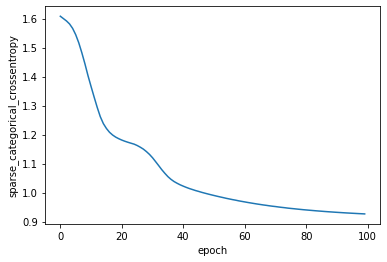

In [6]:
model.train()
history = model.fit(x_train, y_train, epochs=100, batch_size=10)
# 学習曲線のプロット
plt.xlabel("epoch"); plt.ylabel("sparse_categorical_crossentropy")
plt.plot(np.arange(100), history);plt.show()

## 訓練結果を検証する

知らないデータを、どれくらい分類できるか？


**検証するときは、model.eval()と唱えて検証用モードに切り替える。**

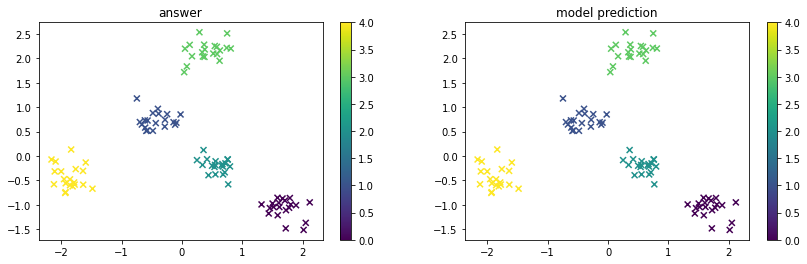

In [7]:
model.eval()

x_unknown, y_unknown = dg.get_data(100)
x_tensor = torch.autograd.Variable(torch.tensor(x_unknown)).float()

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.title("answer")
plt.scatter(x_unknown[:,0], x_unknown[:,1], c=y_unknown, marker="x")
plt.colorbar()

plt.subplot(1,2,2)
plt.title("model prediction")
plt.scatter(x_unknown[:,0], x_unknown[:,1], c=np.argmax(model(x_tensor).data.numpy(), axis=1), marker="x")
plt.colorbar()

plt.show()

## もっと細かいことをやりたい場合

PyTorchはもともと、細かい処理を得意とするので、ぜひ調べてみてください。公式チュートリアル

- https://pytorch.org/tutorials/

を眺めてみるのがいいかと思います。